In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from theano import tensor as tt

In [3]:
Dmat = pd.read_csv('../data_files/island_dist_matrix.csv', sep=",", index_col=0)
Dmat.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


<AxesSubplot:>

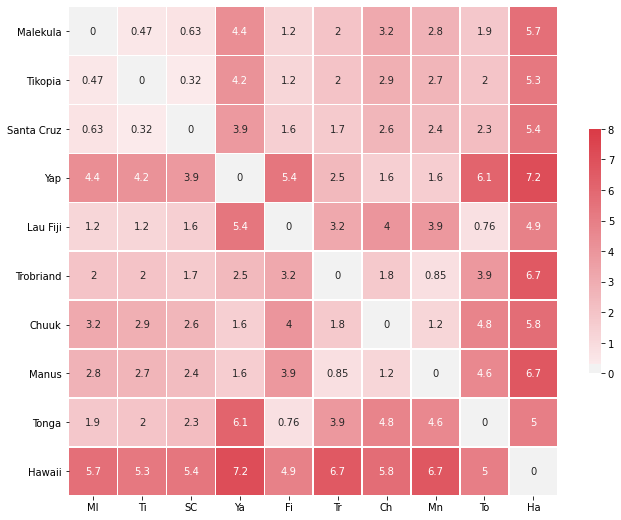

In [141]:
corr = Dmat

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmin=0, vmax=8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

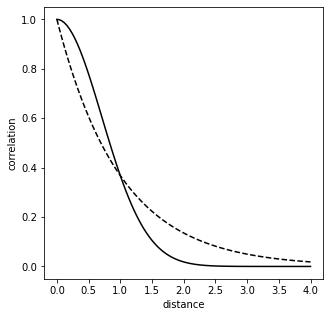

In [13]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
xrange = np.linspace(0, 4, 100)
ax.plot(xrange, np.exp(-1*xrange), 'k--')
ax.plot(xrange, np.exp(-1*xrange**2), 'k')
ax.set_xlabel('distance')
ax.set_ylabel('correlation');

In [4]:
dk = pd.read_csv('../data_files/kline2.csv', sep=",")
Nsociety = dk.shape[0]
dk.loc[:, 'society'] = np.arange(Nsociety)
Dmat_ = Dmat.values
Dmatsq = np.power(Dmat_, 2)

Text(0.5, 0.98, 'Tool counts by contact rates')

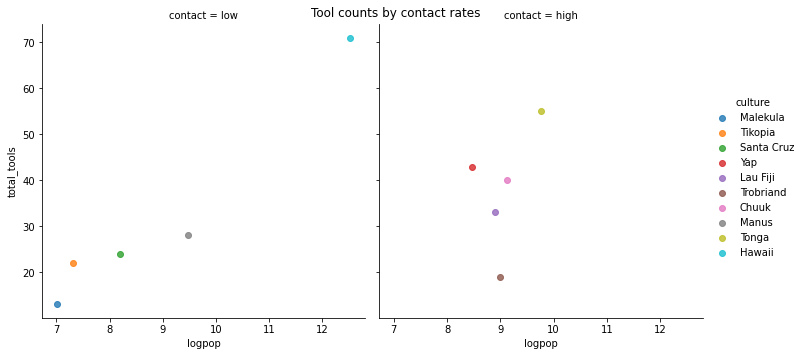

In [53]:
#dk.plot.scatter(x='logpop', y='total_tools')
g = sns.lmplot(x="logpop", y="total_tools", data=dk, hue='culture', col='contact')
axes = g.axes.flatten()
#for ax in axes:
#    ax.axhline(30)
plt.suptitle("Tool counts by contact rates")

In [29]:
#dk.plot.scatter(x='logpop', y='total_tools')
dk.index = dk['culture']
import statsmodels.api as sm
from statsmodels.formula.api import ols
interaction_model = sm.GLM.from_formula("total_tools ~ logpop + C(contact) + logpop*C(contact)", family=sm.families.Poisson(), data=dk).fit()
#interaction_model = ols("total_tools ~ logpop + C(contact)", data=dk).fit()
interaction_model.summary()
no_interaction_model = sm.GLM.from_formula("total_tools ~ logpop", family=sm.families.Poisson(), data=dk).fit()
#interaction_model = ols("total_tools ~ logpop + C(contact)", data=dk).fit()
no_interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_tools   No. Observations:                   10
Model:                            GLM   Df Residuals:                        8
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39.029
Date:                Sun, 17 Oct 2021   Deviance:                       25.292
Time:                        16:44:29   Pearson chi2:                     25.4
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3285      0.304      4.376      0.000       0.733       1.924
logpop         0.2398      0.031      7.689      0.000       0.179       0.301
==============================================================================
"""

Text(0.5, 0.98, 'Poisson Regression - Fitted V Residuals')

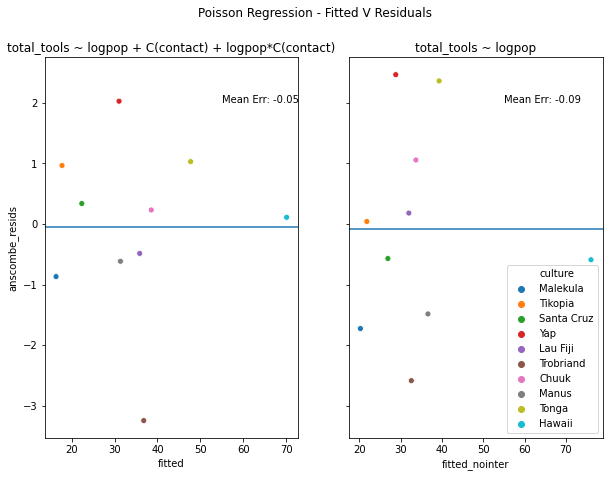

In [58]:
poisson_resid = pd.DataFrame({'fitted': interaction_model.fittedvalues,
              'anscombe_resids': interaction_model.resid_anscombe, 
              'fitted_nointer': no_interaction_model.fittedvalues,
              'anscombe_resids_nointer': no_interaction_model.resid_anscombe,
              'culture': dk.culture})

fig, axs = plt.subplots(1, 2, figsize=(10, 7), sharey=True)
axs = axs.flatten() 
g =sns.scatterplot(data=poisson_resid, x='fitted', y='anscombe_resids', 
hue='culture', ax=axs[0], legend=False)
g =sns.scatterplot(data=poisson_resid, x='fitted_nointer', y='anscombe_resids_nointer', 
hue='culture', ax=axs[1], legend='brief')
axs[0].axhline(poisson_resid['anscombe_resids'].mean())
axs[0].text(55, 2, "Mean Err: {e}".format(e=round(poisson_resid['anscombe_resids'].mean(), 2)))
axs[1].axhline(poisson_resid['anscombe_resids_nointer'].mean())
axs[1].text(55, 2, "Mean Err: {e}".format(e=round(poisson_resid['anscombe_resids_nointer'].mean(), 2)))
axs[1].set_title("total_tools ~ logpop")
axs[0].set_title("total_tools ~ logpop + C(contact) + logpop*C(contact)")
plt.suptitle("Poisson Regression - Fitted V Residuals")


In [65]:
 #Kij = etasq*(tt.exp(-rhosq*Dmatsq)+np.diag([.01]*Nsociety))
 0.01*np.exp(-.6*Dmatsq*np.diag([.01]*Nsociety))

array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]])

In [66]:
with pm.Model() as m_13_7:
    etasq = pm.HalfCauchy('etasq', 1)
    rhosq = pm.HalfCauchy('rhosq', 1)
    Kij = etasq*(tt.exp(-rhosq*Dmatsq)+np.diag([.01]*Nsociety))
    
    g = pm.MvNormal('g', mu=np.zeros(Nsociety), cov=Kij, shape=Nsociety)
    
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 1)
    lam = pm.math.exp(a + g[dk.society.values] + bp*dk.logpop)
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    idata = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a, g, rhosq, etasq]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 106 seconds.
There were 412 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5946647251195668, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


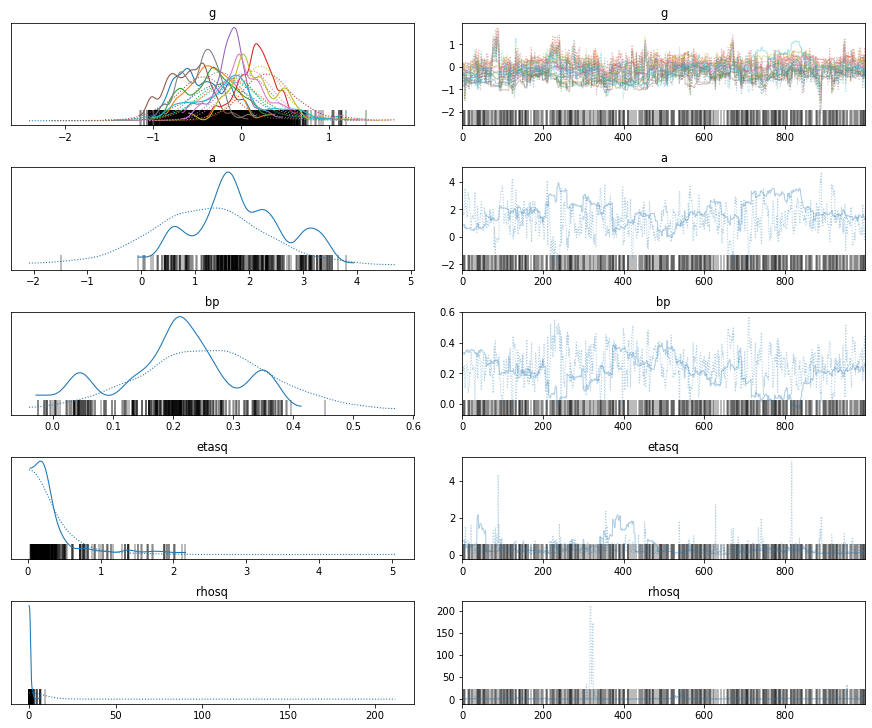

In [67]:

az.plot_trace(idata, var_names=['g', 'a', 'bp', 'etasq', 'rhosq'], compact=True);

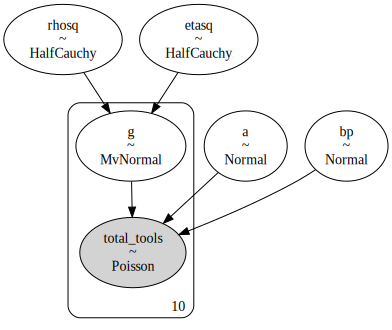

In [68]:
pm.model_to_graphviz( m_13_7)

In [69]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
g[0],-0.337,0.370,-0.957,0.295,0.105,0.076,12.0,12.0,11.0,130.0,1.15
g[1],-0.209,0.351,-0.825,0.382,0.105,0.076,11.0,11.0,10.0,145.0,1.17
g[2],-0.229,0.353,-0.847,0.378,0.105,0.076,11.0,11.0,10.0,146.0,1.16
g[3],0.248,0.296,-0.321,0.748,0.070,0.050,18.0,18.0,14.0,115.0,1.12
g[4],-0.029,0.298,-0.608,0.467,0.084,0.061,13.0,13.0,10.0,132.0,1.17
g[5],-0.520,0.317,-1.059,0.008,0.082,0.059,15.0,15.0,13.0,194.0,1.16
g[6],0.059,0.305,-0.534,0.535,0.097,0.071,10.0,10.0,8.0,133.0,1.19
g[7],-0.347,0.309,-0.937,0.170,0.101,0.073,9.0,9.0,8.0,93.0,1.20
g[8],0.196,0.297,-0.304,0.720,0.076,0.055,15.0,15.0,14.0,65.0,1.15
g[9],-0.102,0.429,-0.863,0.720,0.101,0.073,18.0,18.0,16.0,58.0,1.12


array([<AxesSubplot:title={'center':'etasq'}>,
       <AxesSubplot:title={'center':'rhosq'}>], dtype=object)

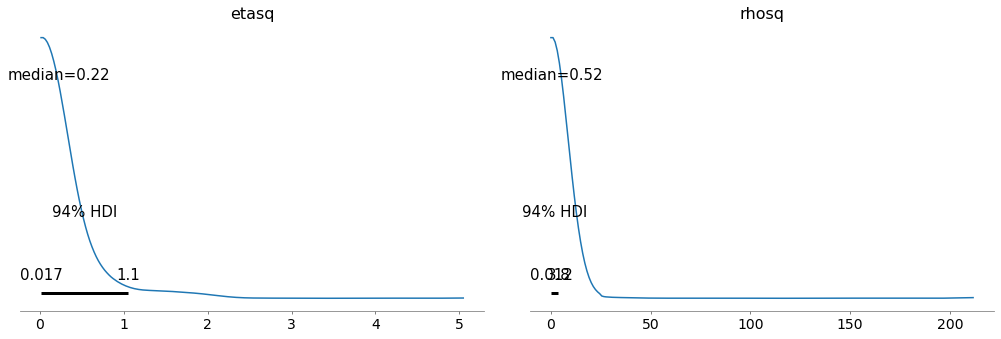

In [73]:
az.plot_posterior(idata, var_names=['etasq', 'rhosq'], point_estimate='median')

Text(0.5, 1.05, 'Draws from Posterior Distribution vof $\\rho^2, \\eta^2$')

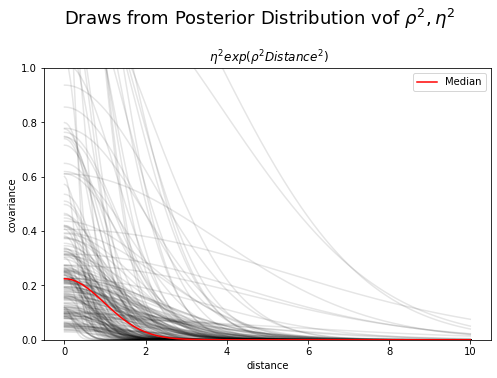

In [156]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, 10, 200)
post_etasq = idata.posterior['etasq'].to_dataframe()
post_rhosq = idata.posterior['rhosq'].to_dataframe()

ax.plot(xrange, (post_etasq.sample(len(xrange)).values * np.exp(-post_rhosq.sample(len(xrange)).values * xrange**2)).T,
        'k', alpha=.1)
ax.plot(xrange, np.median(post_etasq) * np.exp(-np.median(post_rhosq) * xrange**2), 'red', label='Median')
ax.legend()

ax.set_ylim(0, 1)
ax.set_xlabel('distance')
ax.set_ylabel('covariance')
ax.set_title(r' $\eta^2 exp(\rho^2Distance^2)$')
plt.suptitle(r"Draws from Posterior of $\rho^2, \eta^2$", y=1.05, fontsize=18)

In [146]:
# compute posterior median covariance among societies
Kij_post = np.median(post_etasq) * (np.exp(-np.median(post_rhosq) * Dmatsq) + np.diag([.01] * Nsociety))
sigma_post = np.sqrt(np.diag(Kij_post))
Rho = np.diag(sigma_post**-1).dot(Kij_post.dot(np.diag(sigma_post**-1)))
# add row/col names for convenience
Rho = pd.DataFrame(Rho, index=dk['culture'],
                  columns=dk['culture'])

Rho.round(2)

culture,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
culture,,,,,,,,,,
Malekula,1.00,0.88,0.81,0.00,0.45,0.12,0.01,0.02,0.16,0.0
Tikopia,0.88,1.00,0.94,0.00,0.45,0.12,0.01,0.02,0.13,0.0
Santa Cruz,0.81,0.94,1.00,0.00,0.29,0.22,0.03,0.06,0.07,0.0
Yap,0.00,0.00,0.00,1.00,0.00,0.04,0.28,0.26,0.00,0.0
Lau Fiji,0.45,0.45,0.29,0.00,1.00,0.00,0.00,0.00,0.73,0.0
Trobriand,0.12,0.12,0.22,0.04,0.00,1.00,0.18,0.68,0.00,0.0
Chuuk,0.01,0.01,0.03,0.28,0.00,0.18,1.00,0.46,0.00,0.0
Manus,0.02,0.02,0.06,0.26,0.00,0.68,0.46,1.00,0.00,0.0
Tonga,0.16,0.13,0.07,0.00,0.73,0.00,0.00,0.00,1.00,0.0


Text(0.5, 1.0, 'Inferred Correlation Structure between Islands')

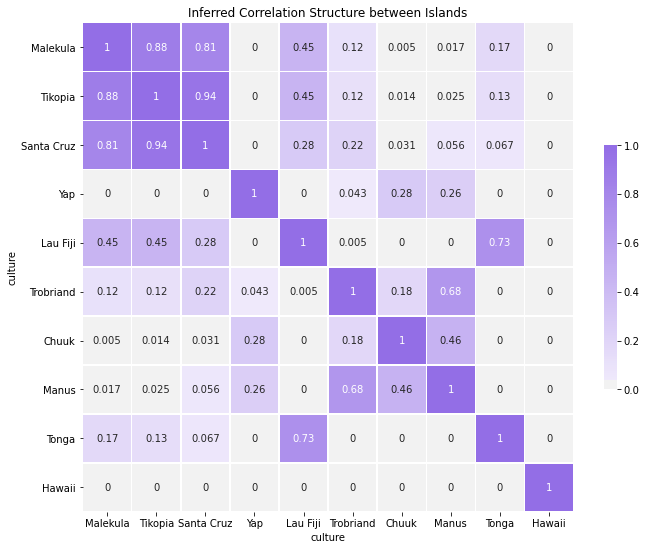

In [151]:
corr = Rho.round(3)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},  annot=True)
plt.title("Inferred Correlation Structure between Islands")